In [54]:
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_val_predict
from scipy.sparse import hstack
from scipy.special import logit, expit

import matplotlib.pyplot as plt
import re
import string
import pickle

import os


In [2]:
class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

train = pd.read_csv('../jigsaw-toxic-comment-classification-challenge/train.csv').fillna(' ')
test = pd.read_csv('../jigsaw-toxic-comment-classification-challenge/test.csv').fillna(' ')

In [3]:
#remove non-ascii characters
def remove_non_ascii(text):
    text  = "".join([char for char in text if char in string.printable])
    text = re.sub('[0-9]+', '', text)
    return text

train['comment_text'] = train['comment_text'].apply(lambda x: remove_non_ascii(x))
test['comment_text'] = test['comment_text'].apply(lambda x: remove_non_ascii(x))

In [4]:
list_sentences_train = train['comment_text']
list_sentences_test = test['comment_text']
all_text = pd.concat([list_sentences_train, list_sentences_test])

In [5]:
len(train)

159571

In [6]:
# toxic = list_sentences_train.loc[train['toxic'] == 1]


In [7]:
# toxic = list_sentences_train.loc[train['toxic'] == 1]
# severe_toxic = list_sentences_train.loc[train['toxic'] == 1]
# obscene = list_sentences_train.loc[train['toxic'] == 1]
# threat = list_sentences_train.loc[train['toxic'] == 1]
# insult = list_sentences_train.loc[train['toxic'] == 1]
# identity_hate = list_sentences_train.loc[train['toxic'] == 1]

# Clean Dataset

In [8]:
cl_path = './cleaning/clean_letters.txt'
clean_word_dict = {}
with open(cl_path, 'r', encoding='utf-8') as cl:
    for line in cl:
        line = line.strip('\n')
        typo, correct = line.split(',')
        clean_word_dict[typo] = correct

def clean_word(text):
    replace_numbers = re.compile(r'\d+', re.IGNORECASE)
    special_character_removal = re.compile(r'[^a-z\d ]', re.IGNORECASE)

    text = text.lower()
    text = re.sub(r"https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0-9@:%_\+.~#?&//=]*)", "", text)
    text = re.sub(r"(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)(\.(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)){3}", "", text)

    for typo, correct in clean_word_dict.items():
        text = re.sub(typo, " " + correct + " ", text)

    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"i’m", "i am", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    text = replace_numbers.sub('', text)
    return text

train_text = []
test_text = []

for text in list_sentences_train:
    train_text.append(clean_word(text))
    
for text in list_sentences_test:
    test_text.append(clean_word(text))
    

# Apply TF-IDF Vectorizer

In [9]:
#used for EFC
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    ngram_range=(1, 1),
    stop_words='english',
    max_features=30000)
word_vectorizer.fit(all_text)

train_word_features = word_vectorizer.transform(train_text)
test_word_features = word_vectorizer.transform(test_text)

In [10]:
# #used for logit
# char_vectorizer = TfidfVectorizer(
#     sublinear_tf=True,
#     strip_accents='unicode',
#     analyzer='word',
#     ngram_range=(1, 1),
#     stop_words='english',
#     max_features=30000)
# char_vectorizer.fit(all_text)

# train_char_features = char_vectorizer.transform(train_text)
# test_char_features = char_vectorizer.transform(test_text)

# Apply CountVectorizers

In [11]:
#used for logit
count_vectorizer = CountVectorizer(
    strip_accents='unicode',
    analyzer='word',
    ngram_range=(1, 1),
    stop_words='english',
    max_features=30000)
count_vec_fit = count_vectorizer.fit(all_text)

train_count_features = count_vectorizer.transform(train_text)
test_count_features = count_vectorizer.transform(test_text)

In [12]:
train_count_features.toarray().sum(axis=0)
count_df = pd.DataFrame(count_vec_fit.get_feature_names())
count_df['counts'] = train_count_features.toarray().sum(axis=0)

# CountVectorizers (for each individual topic/feature)

In [13]:
def count_df_from_toxic_category(category_string):
    '''category string must match train dataframe column name exactly ''' 
    filtered_sentences = list_sentences_train.loc[train[category_string] == 1]
    category_vectorizer = CountVectorizer(
        strip_accents='unicode',
        analyzer='word',
        ngram_range=(1, 1),
        stop_words='english',
        max_features=30000)
    category_vec_fit = category_vectorizer.fit(filtered_sentences)

    category_count_features = category_vectorizer.transform(filtered_sentences)
    category_count_df = pd.DataFrame(category_vec_fit.get_feature_names())
    category_count_df['counts'] = category_count_features.toarray().sum(axis=0)
    category_count_df.rename(columns = {0: 'word'})
    return category_count_df, filtered_sentences

In [14]:
class_names

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [24]:
class_specific_vocab_dict = dict()
class_specific_sentences = dict()
for class_name in class_names:
    class_specific_vocab_dict[class_name] = \
        count_df_from_toxic_category(class_name)[0].sort_values('counts', ascending = False)
    class_specific_sentences[class_name] =\
            count_df_from_toxic_category(class_name)[1]

NameError: name 'count_df_from_toxic_category' is not defined

In [23]:
toxic_string = []
for line in class_specific_sentences['toxic']:
    toxic_string.append(line)

NameError: name 'class_specific_sentences' is not defined

In [22]:
toxic_string

NameError: name 'toxic_string' is not defined

In [ ]:
list(word_vectorizer.transform([toxic_string]).toarray()[0] == word_vectorizer.transform([toxic_string]).toarray().max()).index(1)

In [ ]:
word_vectorizer.get_feature_names()[10704]

In [ ]:
toxic_sentences_transformed = word_vectorizer.transform(class_specific_sentences['toxic']).toarray()

In [ ]:
toxic_sentences_transformed

In [ ]:
toxic_sentences_transformed.sum(axis=0).max()

In [ ]:
class_specific_vocab_dict['identity_hate'].head()

In [ ]:
class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [ ]:
toxic_df = count_df_of_toxic_category('toxic')

In [ ]:
toxic_df.sort_values('counts',ascending = False)

In [ ]:
toxic_df.rename(columns = {0: 'word'})

In [ ]:
word_vectorizer.transform

# Online Code to get top TFIDF Features

In [26]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [27]:
train_word_features

<159571x30000 sparse matrix of type '<class 'numpy.float64'>'
	with 3646472 stored elements in Compressed Sparse Row format>

In [28]:
# Xtr = vec_pipe.fit_transform(X)
# vec = vec_pipe.named_steps['vec']
# features = vec.get_feature_names()

Xtr = train_word_features
features = word_vectorizer.get_feature_names()

In [29]:
# row is word_vectorizer.transformed row

In [30]:
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

In [31]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [32]:
len(train_text)

159571

In [34]:
# word_vectorizer.transform(toxic_string)

In [35]:
def top_feats_in_doc(Xtr, features, row_id, top_n=25):
    ''' Top tfidf features in specific document (matrix row) '''
    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

In [36]:
train['comment_text'][0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now...."

In [37]:
top_feats_in_doc(Xtr,features,0).head() # first comment TFIDF scores

,feature,tfidf
0,dolls,0.326094
1,vandalisms,0.319737
2,metallica,0.306812
3,closure,0.279368
4,hardcore,0.271463


In [38]:
def top_mean_feats(Xtr, features, grp_ids=None, min_tfidf=0.1, top_n=25):
    ''' Return the top n features that on average are most important amongst documents in rows
        indentified by indices in grp_ids. '''
    if grp_ids:
        D = Xtr[grp_ids].toarray()
    else:
        D = Xtr.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

In [39]:
def top_feats_by_class(Xtr, y, features, min_tfidf=0.1, top_n=25):
    ''' Return a list of dfs, where each df holds top_n features and their mean tfidf value
        calculated across documents with the same class label. '''
    dfs = []
    labels = np.unique(y)
    for label in labels:
        ids = np.where(y==label)
        feats_df = top_mean_feats(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

In [ ]:
list_of_toxic_df = top_feats_by_class(Xtr,train['toxic'],features)

In [49]:
list_of_toxic_df[1]

,feature,tfidf
0,fuck,0.047871
1,fucking,0.027268
2,shit,0.019604
3,bitch,0.014764
4,suck,0.014676
5,ass,0.014637
6,stupid,0.013861
7,stop,0.013441
8,u,0.013106
9,asshole,0.012458


In [41]:
list_of_obscene_df = top_feats_by_class(Xtr,train['obscene'],features)
list_of_obscene_df[1]

In [ ]:
list_of_identity_df = top_feats_by_class(Xtr,train['identity_hate'],features)

In [51]:
list_of_identity_df[1]

,feature,tfidf
0,gay,0.066806
1,fuck,0.053866
2,faggot,0.046113
3,nigger,0.042009
4,fucking,0.038894
5,shit,0.025319
6,bitch,0.021185
7,ass,0.020489
8,u,0.019978
9,jew,0.017709


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24])

<BarContainer object of 25 artists>

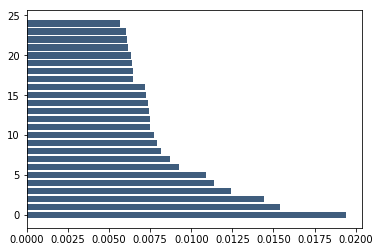

In [62]:
plt.barh(np.arange(len(list_of_toxic_df[0])), list_of_toxic_df[0].tfidf, align='center', color='#3F5D7D')

In [55]:
def plot_tfidf_classfeats_h(dfs):
    ''' Plot the data frames returned by the function plot_tfidf_classfeats(). '''
    fig = plt.figure(figsize=(12, 9), facecolor="w")
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(1, len(dfs), i+1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel("Mean Tf-Idf Score", labelpad=16, fontsize=14)
        ax.set_title("label = " + str(df.label), fontsize=16)
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.tfidf, align='center', color='#3F5D7D')
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1]+1])
        yticks = ax.set_yticklabels(df.feature)
        plt.subplots_adjust(bottom=0.09, right=0.97, left=0.15, top=0.95, wspace=0.52)
    plt.show()

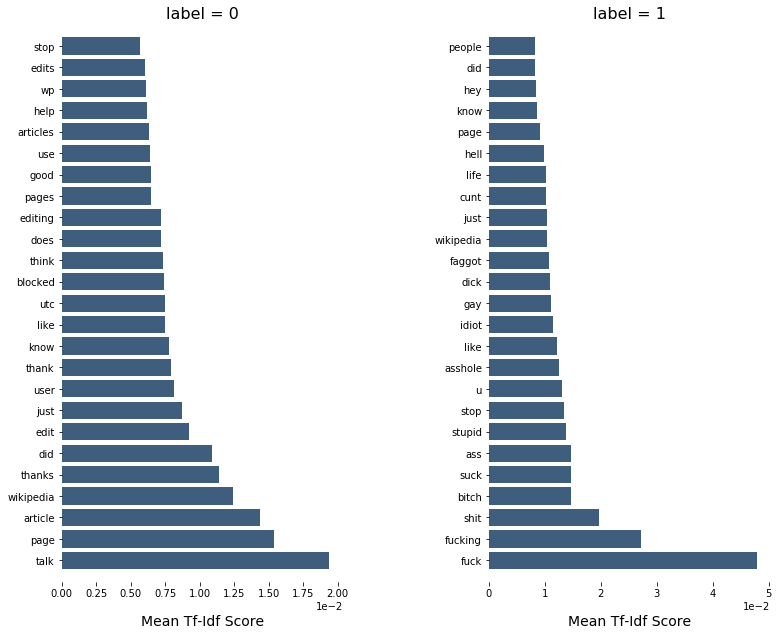

In [56]:
plot_tfidf_classfeats_h(list_of_toxic_df)

# Applying Logistic Regression

In [6]:
#this is kept for heroku purposes
train_features = train_word_features
test_features = test_word_features

In [7]:
losses = []
log_predictions = {'id': test['id']}
log_models = {}
for class_name in class_names:
    train_target = train[class_name]
    log_classifier = LogisticRegression(solver='sag')
    log_classifier.fit(train_features, train_target)
    
    print('Accuracy of logistic regression classifier on {} set: {:.5f}'.format(class_name,log_classifier.score(train_features, train_target)))
    
    cv_loss = np.mean(cross_val_score(log_classifier, train_features, train_target, cv=3, scoring='roc_auc'))
    losses.append(cv_loss)
    print('CV score for class {} is {}'.format(class_name, cv_loss))
    
    log_models[class_name] = log_classifier
    log_predictions[class_name] = log_classifier.predict_proba(test_features)[:, 1]

Accuracy of logistic regression classifier on toxic set: 0.96308
CV score for class toxic is 0.9720911734100458
Accuracy of logistic regression classifier on severe_toxic set: 0.99131
CV score for class severe_toxic is 0.9850439260374024
Accuracy of logistic regression classifier on obscene set: 0.97990
CV score for class obscene is 0.9849794924921239
Accuracy of logistic regression classifier on threat set: 0.99737
CV score for class threat is 0.9860592598384071
Accuracy of logistic regression classifier on insult set: 0.97404
CV score for class insult is 0.9779611194696516
Accuracy of logistic regression classifier on identity_hate set: 0.99249
CV score for class identity_hate is 0.9755127187544805
